In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

чтение данных

In [23]:
data = pd.read_csv('diabetes.csv')
print(data)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

разделение данных на тестовый и обучающий набор 

In [24]:
X = data.drop(["Outcome"], axis=1)
y = data["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [25]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 

вспомогательная функция для получения информации о метриках

In [26]:
def metrics_info(y, y_pred):
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("F1:", f1_score(y, y_pred))

логистическая регрессия: обучение и получение информации о метриках

In [27]:
clf = LogisticRegression(random_state=0, max_iter=250)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print("логистическая регрессия\n")
print("train set")
metrics_info(y_train, y_pred)
print("\ntest set")
y_pred = clf.predict(X_test)
metrics_info(y_test, y_pred)

логистическая регрессия

train set
Accuracy: 0.7608695652173914
Precision: 0.7007299270072993
Recall: 0.5818181818181818
F1: 0.6357615894039735

test set
Accuracy: 0.788961038961039
Precision: 0.7638888888888888
Recall: 0.5339805825242718
F1: 0.6285714285714286


обучающее дерево: обучение и получение информации о метриках

In [28]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print("обучающее дерево\n")
print("train set")
metrics_info(y_train, y_pred)
print("\ntest set")
y_pred = clf.predict(X_test)
metrics_info(y_test, y_pred)

обучающее дерево

train set
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

test set
Accuracy: 0.6915584415584416
Precision: 0.5416666666666666
Recall: 0.5048543689320388
F1: 0.5226130653266332


Решающее дерево с параметрами по умолчанию сильно переобучилось. Сейчас лучше обобщает датасет модель логистической регрессии. Но стоит попробовать подобрать гиперпараметры решающего дерева, чтобы оно не переобучалось. И возможно тогда нам удастся получить качество лучше чем у линейной модели.

для иссмледования зависимости метрики от глубины решающего дерева, возьмем метрику F1. Так как метрика F1 объединяет Recall и Precision, используя их гармоническое среднее. Максимизация оценки F1 подразумевает одновременное максимизирование упомянутых метрик.

построим график зависимости глубины от метрики F1

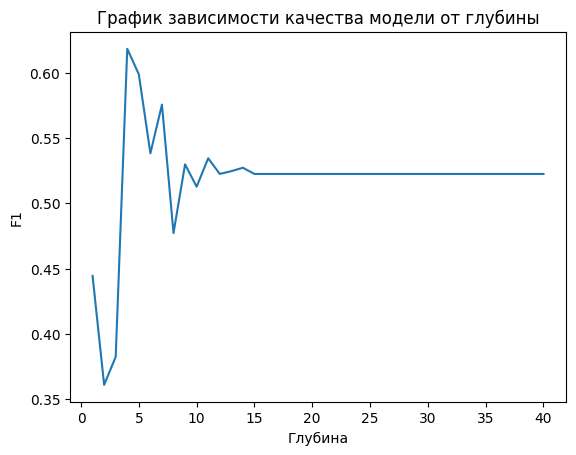

In [29]:
import matplotlib.pyplot as plt
f1s = []
depths = range(1, 41)
best_depth = -1
max_f1 = 0
for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1s.append(f1)
    if f1 > max_f1:
        max_f1 = f1
        best_depth = depth
plt.plot(depths, f1s)
plt.xlabel("Глубина")
plt.ylabel("F1")
plt.title("График зависимости качества модели от глубины")
plt.show()

In [30]:
print(f"наилучшее значение F1 - {max_f1} и соответсвующая глубина - {best_depth}")

наилучшее значение F1 - 0.6185567010309279 и соответсвующая глубина - 4


таким образом, мы получили модель с таким же хорошим качеством, как и у логистической регресси. 

построим соответсвеюющее дерево.

In [31]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
from sklearn import tree
import graphviz

In [33]:
tree_model = DecisionTreeClassifier(max_depth=best_depth)
tree_model.fit(X_train, y_train)
dot_data = tree.export_graphviz(tree_model, out_file=None, 
                     feature_names=data.columns[:-1],  
                     class_names=["0", "1"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

построис важность признаков (feature importances) в виде столбчатой диаграммы

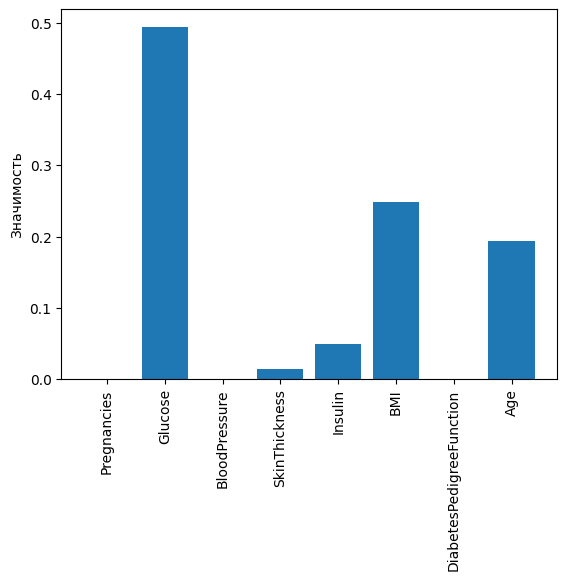

In [34]:
plt.bar(data.columns[:-1], tree_model.feature_importances_)
plt.ylabel("Значимость")
plt.tick_params(axis='x', rotation=90)

построим RC и ROC кривые

In [35]:
from sklearn.metrics import precision_recall_curve, roc_curve
y_pred_probs = tree_model.predict_proba(X_test)[:, 1]

Text(0.5, 1.0, 'PR кривая')

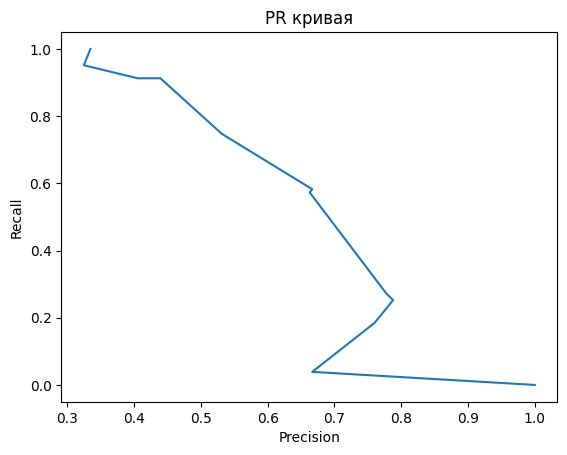

In [36]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
plt.plot(precision, recall)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR кривая")

Text(0.5, 1.0, 'ROC кривая')

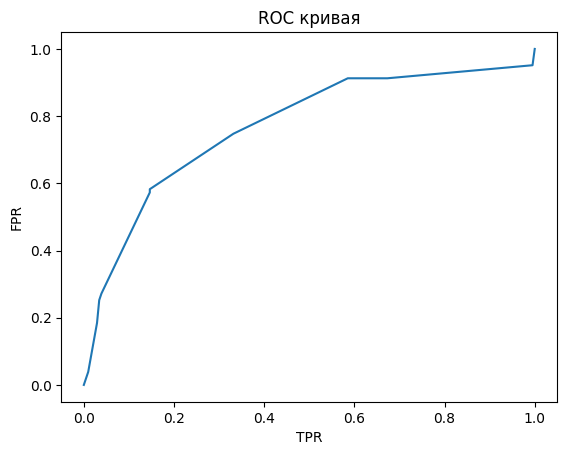

In [37]:
TPR, FPR, _ = roc_curve(y_test, y_pred_probs)
plt.plot(TPR, FPR)
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC кривая")